In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [ ]:
Determining whether a document image is upright or upside down using Python without reading the content by OCR can be challenging, but it’s possible with a statistical approach. Here’s a general idea:
Image Processing: Convert the image to grayscale and apply a Gaussian blur to reduce noise. Then, threshold the image to convert it to binary, which will make the text regions stand out.
Text Region Detection: Find regions in the image that likely contain text. This can be done by looking for connected components in the binary image. You can use morphological operations, like dilation, to connect nearby text regions.
Orientation Estimation: For each detected text region, calculate the orientation of the region. One way to do this is by fitting a minimum area rectangle around the region and calculating the angle of the rectangle. The assumption here is that the longer side of the rectangle aligns with the direction of the text.
Majority Voting: After calculating the orientation for all text regions, decide the overall orientation of the document based on the most common orientation (i.e., the mode of the orientations).
This approach is less compute-intensive than OCR as it doesn’t involve character recognition. However, it assumes that the majority of the text in the document is oriented the same way. If the document contains text in multiple orientations, this method might not work well. Also, this method might not distinguish between a document being upside down (rotated 180 degrees) versus right side up, as text regions would have the same orientation in both cases.



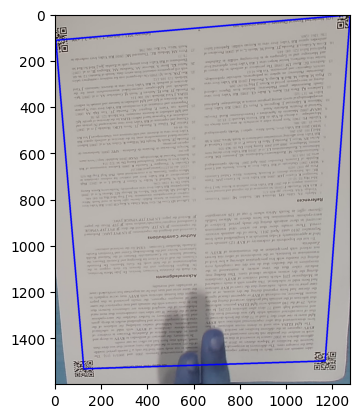

In [2]:
image = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_17.MP4_11930.png')
plt.imshow(image)

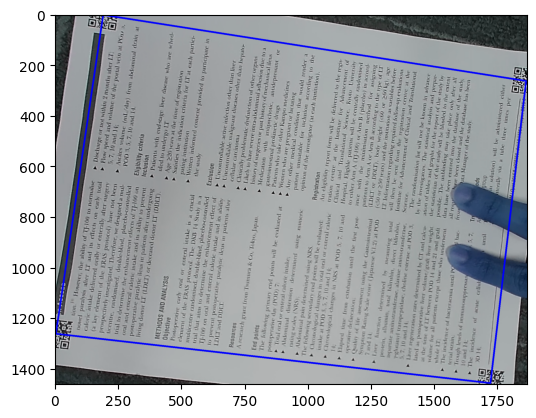

In [3]:
image2 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_12.mp4_2190.png')
plt.imshow(image2)

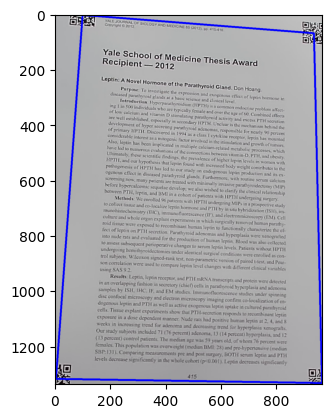

In [4]:
image3 = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_cropped_aoi/_20230918_144316.MP4_96.png')
plt.imshow(image3)

In [10]:
from skimage.transform import rotate
from skimage.color import rgb2gray
from deskew import determine_skew

min_angle, max_angle = -5,5
qry_image_size = (1600, 2000)
def deskew(image):
    grayscale = rgb2gray(image)
    angle = np.round(determine_skew(grayscale),1)
    print("angle:", angle)
    if angle < max_angle and angle < min_angle:
        return image
    rotated = (rotate(image, angle, resize=True) * 255).astype(np.uint8)
    rotated_norm = cv2.resize(rotated,qry_image_size,interpolation = cv2.INTER_LINEAR)
    rotated_norm2 = (rotate(rotated_norm, 180, resize=True) * 255).astype(np.uint8)

    return rotated_norm, rotated_norm2

In [ ]:
_=deskew(image)

In [ ]:
_=deskew(image2)

In [ ]:
_=deskew(image3)

In [ ]:
def binarize(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,129,4)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    result = 255 - opening
    return result

#generate_stats components into a dataframe
def generate_stats(totalLabels,stats, centroids):
    '''
    totalLabels,stats, centroids : cv2 connectedComponentsWithStats outputs
    '''
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

#filter 
def filter_cv2_components(df, min_ar_thresh=1, max_ar_thresh=10,pixel_row_gap = 10):
    '''
    df : dataframe,
    min_ar_thresh : min aspect ratio threshold,
    max_ar_thresh : max aspect ratio threshold,
    pixel_row_gap : min gap b/w pixels to consider them in difft rows
    '''

    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    # df = df[(df['aspect_ratio'] > min_ar_thresh) & (df['aspect_ratio'] < max_ar_thresh)]  #filter by aspect-ratio
    # df = df[(df['area'] > min_area) & (df['area'] < max_area)]  #filter by area
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True) #sort-by occurence
    
    #calculate rowID, colID
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > pixel_row_gap:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)
    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df


def build_single_lexicon(label_id, df, k=5):
    '''
    label_id : word component id, 
    df : dataframe
    k : #neighbors to build context
    '''
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    
    #filter by current component and extract candidate neighbors
    x,y,w,h,r,c = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #rotation-invariance - TBD during preprocessing
    
    #scale-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)/w
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])/h
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/h
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/h
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0 #heuristic
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0 #heuristic
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
    
    #sort and retreive top-K, format required coordinates.
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k] #sort and get top-k neighbors
    res_df = res_df.sort_values(by=['theta'])
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           
    return res_df

def print_components(image,df,comps=None):
    output = image.copy() #np.zeros(image.shape)#image.copy() 
    if comps is None:
        comps = df['label_id'].values
    for comp in comps:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # print(comp,":",dist, area,(w,h),(x, y), (x + w, y + h),thresh[x:x+w,y:y+h])
    print("no of components:", df.shape[0])
    plt.imshow(output)
    plt.title("components")
    plt.show()


In [ ]:
def build_context_layout(img,k_neigh = 5):
    '''
    img : image, 
    k_neigh : #neighbors to build context
    '''
    #preprocess and transform image
    thresh = binarize(img)
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(thresh,4,cv2.CV_32S)
    df = generate_stats(totalLabels,stats, centroid)
    df = filter_cv2_components(df)
    print_components(img,df)
    return df

In [ ]:
disk1, disk2 = deskew(image)
df1 = build_context_layout(disk1)
df2 = build_context_layout(disk2)

In [ ]:
x1, y1, w1, h1, area = df1[df1['label_id'] == 100][['left','top','width','height','area']].values[0]
cc1 = disk1[y1:y1+h1,x1:x1+w1].copy()
plt.imshow(cc1, cmap='gray')
plt.show()

In [ ]:
gray1 = binarize(cc1)
plt.imshow(gray1,cmap='gray')

In [ ]:
kernel = np.array([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]])
plt.imshow(kernel, cmap='gray')

In [ ]:
# canvas = np.ones(cc1.shape, dtype=np.uint8)
dst = cv2.filter2D( cc1, -1, kernel)
plt.imshow(dst)

In [ ]:
# canvas = np.ones(cc1.shape, dtype=np.uint8)
dst = cv2.filter2D( gray1, -1, kernel)
plt.imshow(dst,cmap='gray')

In [ ]:
h,w = dst.shape
up = dst[:h//2,:]
plt.imshow(up,cmap='gray')
plt.show()

In [ ]:
down = dst[h//2+1:,:]
plt.imshow(down,cmap='gray')
plt.show()

In [ ]:
up.mean(), down.mean()

In [ ]:
def find_angle = 

In [ ]:

plt.imshow(disk2, cmap='gray')


In [ ]:
x2, y2, w2, h2, area = df2[df2['label_id'] == 150][['left','top','width','height','area']].values[0]
cc2 = disk2[y2:y2+h2,x2:x2+w2].copy()
plt.imshow(cc2, cmap='gray')
plt.show()

In [ ]:
gray2 = binarize(cc2)
plt.imshow(gray2,cmap='gray')

In [ ]:
kernel = np.array([[-1, -1],
                   [1, 1]])
plt.imshow(kernel, cmap='gray')

In [ ]:
# canvas = np.ones(cc1.shape, dtype=np.uint8)
dst2 = cv2.filter2D( cc2, -1, kernel)
plt.imshow(dst2)

In [ ]:
# canvas = np.ones(cc1.shape, dtype=np.uint8)
dst2 = cv2.filter2D( gray2, -1, kernel)
plt.imshow(dst2,cmap='gray')

In [ ]:
h,w = dst2.shape
up = dst2[:h//2,:]
plt.imshow(up,cmap='gray')
plt.show()

In [ ]:
down = dst2[h//2+1:,:]
plt.imshow(down,cmap='gray')
plt.show()

In [ ]:
up.mean(), down.mean()

In [ ]:
def find_angle(img, df):
    for row in df.iterrows():
        x, y, w, h = row[1].values[[1,2,3,4]].astype(int)
        cc = img[y:y+h,x:x+w].copy()
        plt.imshow(cc ,cmap='gray')
        plt.show()
        break
find_angle(disk1, df1)

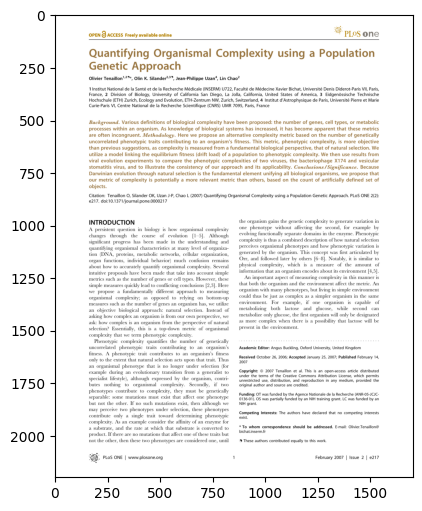

In [18]:
pdf = cv2.imread('/home/csgrad/indratej/my_projects/thesis/IC-dataset/final_optimal_gt/_6.mp4_2365.png')
plt.figure(figsize=(10,6))
plt.imshow(pdf)

In [35]:
def get_keypoints(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray,None)
    img2 = cv2.drawKeypoints(image.copy(), keypoints, None, flags=0)
    plt.imshow(gray,cmap='gray')
    plt.show()
    kp_angles = np.array([kp.angle for kp in keypoints])
    plt.hist(kp_angles,bins=12)
    plt.show()
    print(kp_angles.mean() , np.median(kp_angles) ,stats.mode(kp_angles))
    return keypoints

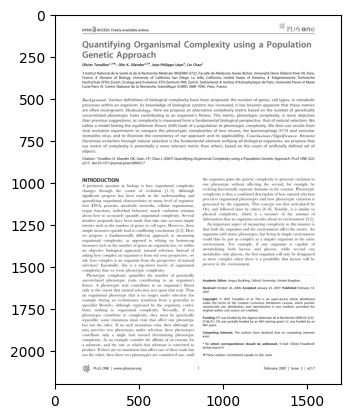

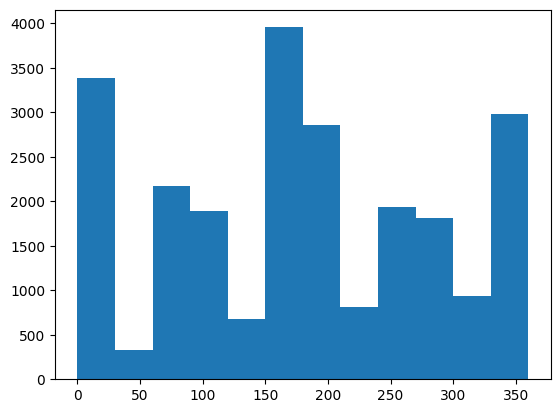

179.1861554989888 178.00794982910156 ModeResult(mode=6.522712707519531, count=30)


In [36]:
_ = get_keypoints(pdf)

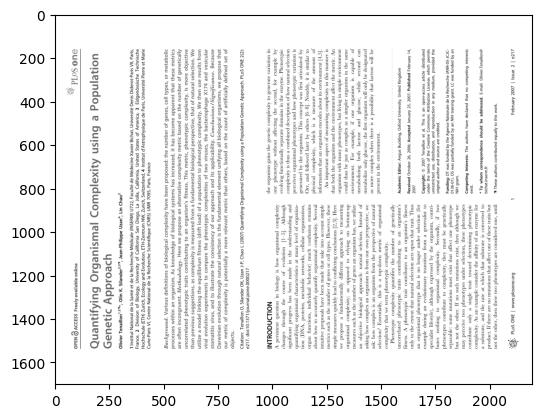

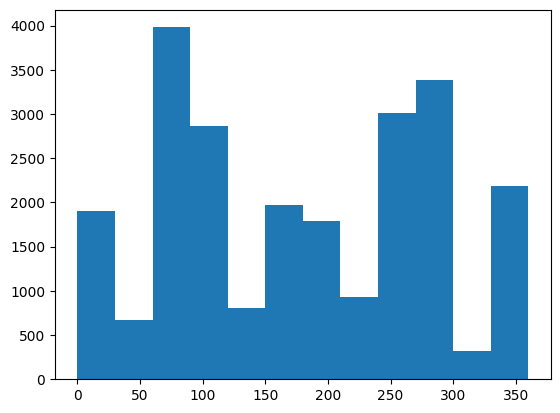

178.4033773055982 178.79373168945312 ModeResult(mode=79.80514526367188, count=21)


In [37]:
pdf1 = (rotate(pdf.copy(), 90, resize=True) * 255).astype(np.uint8)
_ = get_keypoints(pdf1)

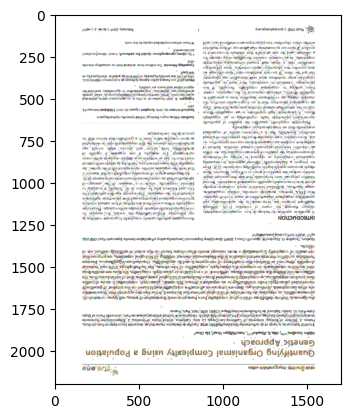

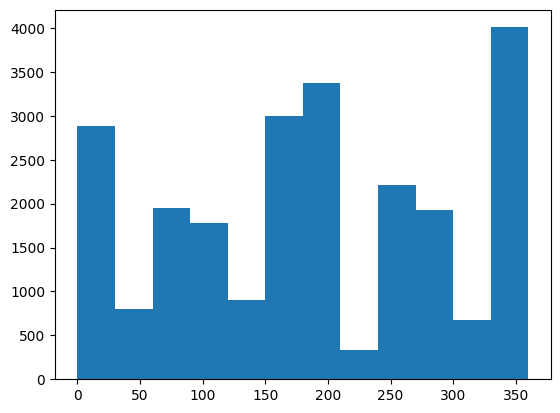

188.03459852936382 182.5088119506836 ModeResult(mode=186.52130126953125, count=13)


In [25]:
pdf2 = (rotate(pdf.copy(), 180, resize=True) * 255).astype(np.uint8)
_ = get_keypoints(pdf2)

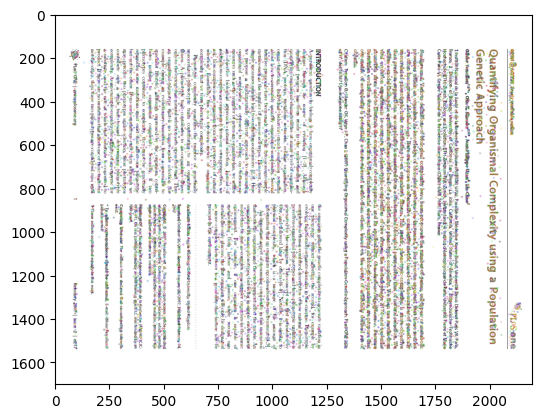

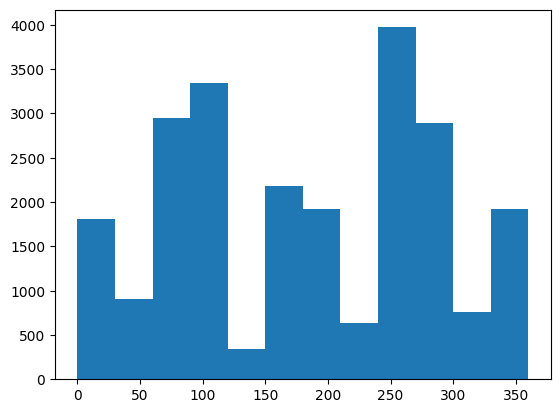

182.61154785117495 180.63350677490234 ModeResult(mode=307.895751953125, count=13)


In [26]:
pdf3 = (rotate(pdf.copy(), 270, resize=True) * 255).astype(np.uint8)
_ = get_keypoints(pdf3)

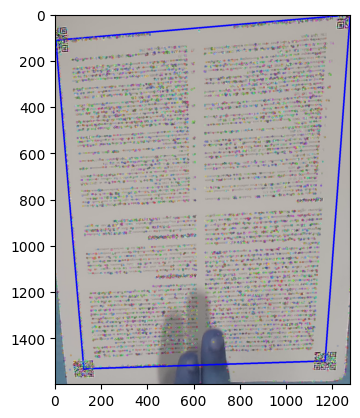

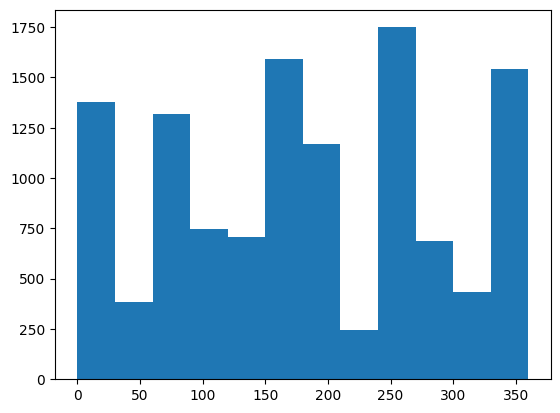

182.6183926626647 178.69070434570312 ModeResult(mode=355.0309753417969, count=11)


In [27]:
_ = get_keypoints(image)

angle: -5.0


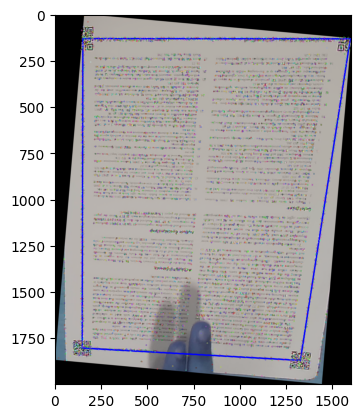

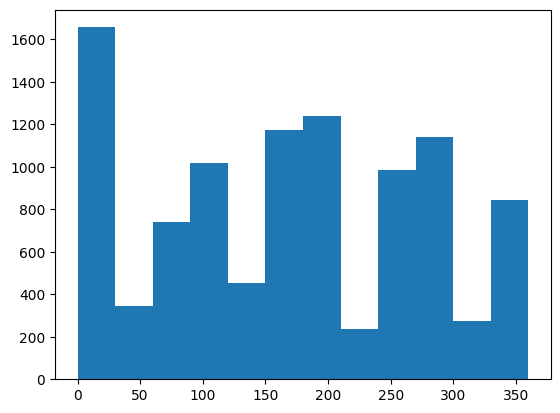

167.8169709045108 176.41064453125 ModeResult(mode=7.5966644287109375, count=2)


In [29]:
a,b = deskew(image)
_ = get_keypoints(a)

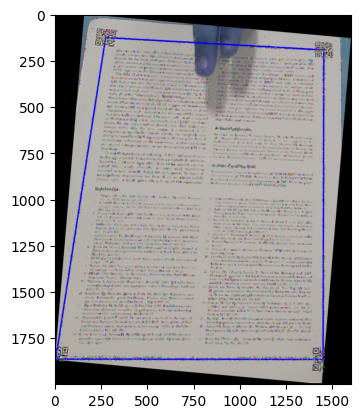

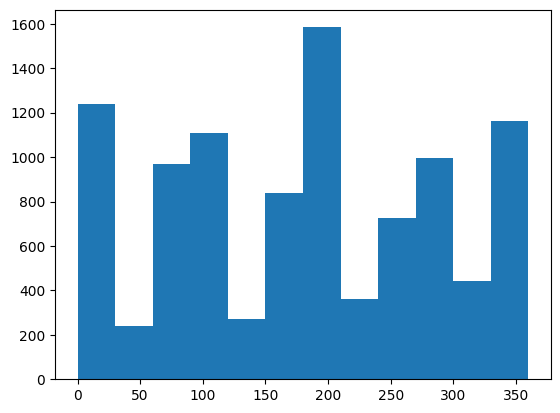

179.33575417079197 182.85179138183594 ModeResult(mode=91.53268432617188, count=2)


In [30]:
_ = get_keypoints(b)

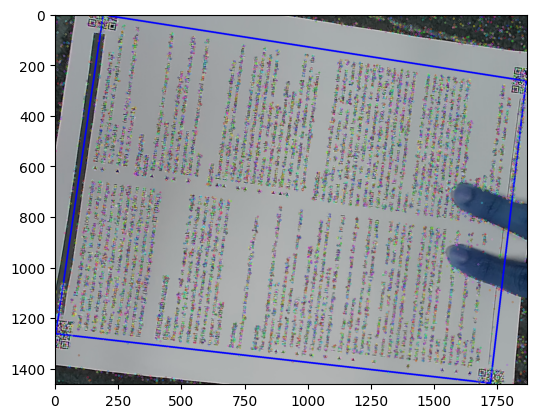

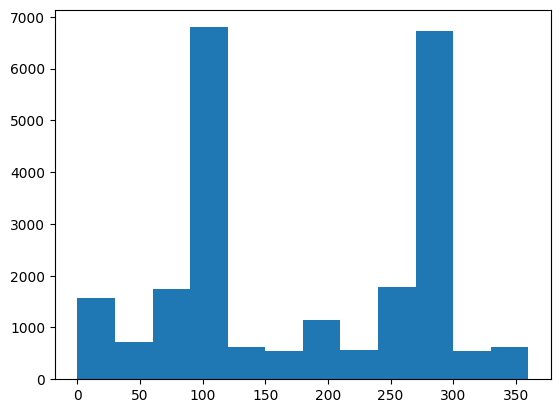

175.69160706706398 165.28929138183594 ModeResult(mode=6.445579528808594, count=2)


In [31]:
_ = get_keypoints(image2)

angle: 8.0


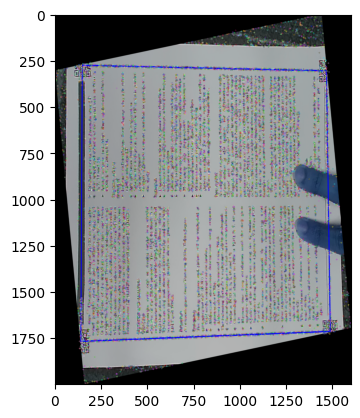

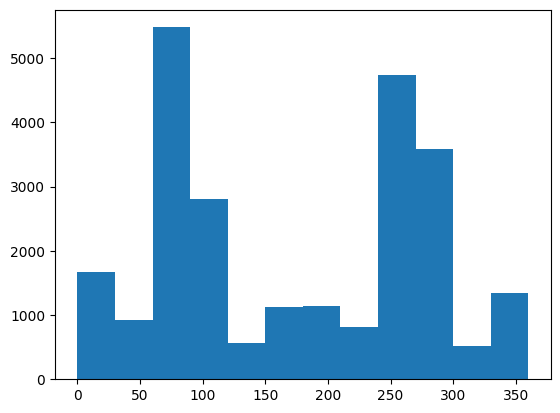

174.81772771098363 177.49463653564453 ModeResult(mode=0.41576385498046875, count=2)


In [32]:
c,d = deskew(image2)
_ = get_keypoints(c)

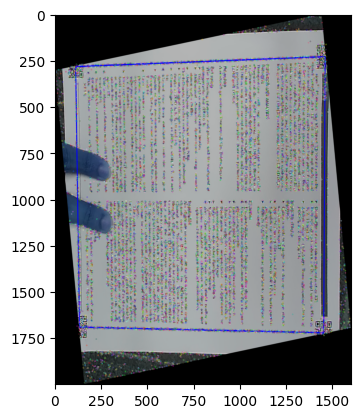

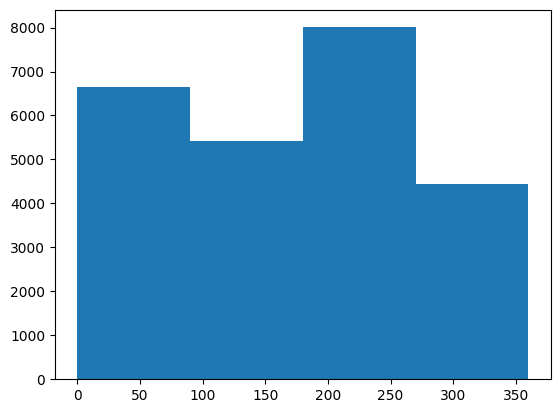

177.67309503833204 181.4156036376953 ModeResult(mode=269.08880615234375, count=3)


In [15]:
_ = get_keypoints(d)

In [1]:
import os
import cv2
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
import numpy as np
from collections import defaultdict
from sklearn.cluster import MeanShift

In [12]:
layouts = list(np.random.rand(100, 5,4))
clusterer = MeanShift()
def compute_clusters(layout):
    return clusterer.fit(layout.reshape(1, -1)).labels_
cluster_labels = Parallel(n_jobs=-1)(delayed(compute_clusters)(layout) for layout in layouts)
len(cluster_labels)
# cluster_centers = clusterer.cluster_centers_

100